STEVEN SZACHARA

DSCI633 FINAL PROJECT

LOADING UP THE DATASET INTO THE X AND y

In [3]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets


/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


After looking at the features and how they correlate using a random forest classifier in Final_Project_1, I determined the below columns to drop in order to not only speed up performance, but to eliminate the features that will skew the model

Also converted y to a binary classification

In [5]:
##drop columns to improve performance and to eliminate noise
from sklearn.preprocessing import LabelEncoder
X = X.drop('weight', axis=1, errors='ignore')
columns_to_drop = [
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'payer_code', 'max_glu_serum', 'metformin', 'number_diagnoses'
]

# Drop the columns
X = X.drop(columns=columns_to_drop, axis=1, errors='ignore')

##convert y to binary, YES if <30, NO for any other
y_binary = ['NO' if (x == 'NO' or x == '>30') else 'YES' for x in y['readmitted']]
##then do 0 for all NOs, 1 for all YES(<30)
y = LabelEncoder().fit_transform(y_binary)

Eliminate any unknown gender, which I found to be only 3 entries, in the dataset from both X and y

In [200]:
# Assuming 'gender' is one of the columns in X
# Step 1: Filter out rows where gender is not 'Male' or 'Female'
valid_gender = X['gender'].isin(['Male', 'Female'])
# Step 2: Apply this filter to both X (features) and y (target)
X = X[valid_gender]
y = y[valid_gender]

Group the diagnosis columns into categories to streamline model performance, and to eliminate noise, drop the original columns and add the new columns into X

In [201]:
# Function to map ICD-9 codes to groups
def map_icd9_to_group(icd9_code):
    try:
        # Ensure the code is a string before splitting
        code_str = str(icd9_code)
        code = float(code_str.split('.')[0])  # Handle decimal codes
    except (ValueError, AttributeError):
        return 'Other'  # For codes that can't be converted to float

    if (250.000001 <= code <= 250.999999):
        return 'Diabetes'
    if (390 <= code <= 459) or code == 785:
        return 'Circulatory'
    if (460 <= code <= 519) or code == 786:
        return 'Respiratory'
    if (520 <= code <= 579) or code == 787:
        return 'Digestive'
    if (800 <= code <= 999):
        return 'Injury'
    if (710 <= code <= 739):
        return 'Musculoskeletal'
    if (580 <= code <= 629) or code == 788:
        return 'Genitourinary'
    if (140 <= code <= 239):
        return 'Neoplasms'
    return 'Other'

# Apply mapping to a diagnosis column
# Replace 'diag_1' with the correct column name in your dataset
if 'diag_1' in X.columns:  # Replace 'diag_1' with the ICD-9 column name in X
    X['D1'] = X['diag_1'].apply(map_icd9_to_group)
    X = X.drop(columns=['diag_1'])
if 'diag_2' in X.columns:  # Replace 'diag_2' with the ICD-9 column name in X
    X['D2'] = X['diag_2'].apply(map_icd9_to_group)
    X = X.drop(columns=['diag_2'])
if 'diag_3' in X.columns:  # Replace 'diag_3' with the ICD-9 column name in X
    X['D3'] = X['diag_3'].apply(map_icd9_to_group)
    X = X.drop(columns=['diag_3'])
else:
    print("Diagnosis column not found in dataset!")

# Check results
print(X.columns)

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'A1Cresult', 'change', 'diabetesMed', 'D1', 'D2',
       'D3'],
      dtype='object')


Checking to see if the gender has accurately been put into only 2 categories

In [202]:
value_counts = X['gender'].value_counts()
print("Value counts in the column:")
print(value_counts)

Value counts in the column:
gender
Female    54708
Male      47055
Name: count, dtype: int64


Checking to see if the diagnosis have been properly converted to new categories

In [203]:
value_counts = X['D1'].value_counts()
print("Value counts in the column:")
print(value_counts)
value_counts = X['D2'].value_counts()
print("Value counts in the column:")
print(value_counts)
value_counts = X['D3'].value_counts()
print("Value counts in the column:")
print(value_counts)

Value counts in the column:
D1
Circulatory        30436
Other              26950
Respiratory        14423
Digestive           9475
Injury              6972
Genitourinary       5117
Musculoskeletal     4957
Neoplasms           3433
Name: count, dtype: int64
Value counts in the column:
D2
Other              39705
Circulatory        31880
Respiratory        10895
Genitourinary       8376
Digestive           4170
Neoplasms           2547
Injury              2426
Musculoskeletal     1764
Name: count, dtype: int64
Value counts in the column:
D3
Other              47774
Circulatory        30305
Respiratory         7358
Genitourinary       6680
Digestive           3930
Injury              1945
Musculoskeletal     1915
Neoplasms           1856
Name: count, dtype: int64


Checking admission type id to see what the status of that column is to be able to streamline the features better

In [204]:
value_counts = X['admission_type_id'].value_counts()
print("Value counts in the column:")
print(value_counts)

Value counts in the column:
admission_type_id
1    53988
3    18868
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: count, dtype: int64


Below converts admission_type_id to just 2 categories

In [205]:
##emergency, urgent, or elective in admission ID, then other
def admission_type_(type_id):
    if (type_id == 1 or type_id == 2):
        return 1
    return 2

if 'admission_type_id' in X.columns:
    X['admission_typeID'] = X['admission_type_id'].apply(admission_type_)
    X = X.drop(columns=['admission_type_id'])
else:
    print("Diagnosis column not found in dataset!")
value_counts = X['admission_typeID'].value_counts()
print("Value counts in the column:")
print(value_counts)

Value counts in the column:
admission_typeID
1    72468
2    29295
Name: count, dtype: int64


Below removes the discharge dispositions rows in both X and y where the patients either die or sent to hospice

Then condense discharge disposition to either sending back home, or other, to streamline the model

In [206]:
##remove discharge to hospice or death
valid_discharge = ~X['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21])
X = X[valid_discharge]
y = y[valid_discharge]
##then do discharge to home or otherwise
def discharge_disposition_(d_id):
    if (d_id == 1):
        return 1
    # Other
    return 2

if 'discharge_disposition_id' in X.columns:
    X['discharge_dispID'] = X['discharge_disposition_id'].apply(discharge_disposition_)
    X = X.drop(columns=['discharge_disposition_id'])
else:
    print("Diagnosis column not found in dataset!")
value_counts = X['discharge_dispID'].value_counts()
print("Value counts in the column:")
print(value_counts)

Value counts in the column:
discharge_dispID
1    60232
2    39108
Name: count, dtype: int64


<ipython-input-206-f5fa419be500>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['discharge_dispID'] = X['discharge_disposition_id'].apply(discharge_disposition_)


Below is to adjust the admission source to just 3 categories, emergency, referral, or otherwise

In [207]:
##admission source from emergency, referral, or otherwise
def admission_source_(s_id):
    if (s_id == 1 or s_id == 2):
        return 1
    if (s_id == 7):
        return 2
    # Add other group mappings here as needed
    return 3

if 'admission_source_id' in X.columns:  # Replace 'diag_1' with the ICD-9 column name in X
    X['admission_sourceID'] = X['admission_source_id'].apply(admission_source_)
    X = X.drop(columns=['admission_source_id'])
else:
    print("Diagnosis column not found in dataset!")
value_counts = X['admission_sourceID'].value_counts()
print("Value counts in the column:")
print(value_counts)

Value counts in the column:
admission_sourceID
2    55848
1    30248
3    13244
Name: count, dtype: int64


The below condenses the medical_specialty into just 6 categories instead of the long list below to eliminate noise and reduce model run-time

In [208]:
##speciality fixed down to 6
value_counts = X['medical_specialty'].value_counts()
print("Value counts in the column:")
print(value_counts)

import pandas as pd

# List of specialties
specialties = [
    'AllergyandImmunology', 'Anesthesiology', 'Anesthesiology-Pediatric', 'Cardiology', 'Cardiology-Pediatric', 'DCPTEAM',
    'Dentistry', 'Dermatology', 'Emergency/Trauma', 'Endocrinology', 'Endocrinology-Metabolism', 'Family/GeneralPractice',
    'Gastroenterology', 'Gynecology', 'Hematology', 'Hematology/Oncology', 'Hospitalist', 'InfectiousDiseases', 'InternalMedicine',
    'Nephrology', 'Neurology', 'Neurophysiology', 'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics', 'ObstetricsandGynecology',
    'Oncology', 'Ophthalmology', 'Orthopedics', 'Orthopedics-Reconstructive', 'Osteopath', 'Otolaryngology', 'OutreachServices',
    'Pathology', 'Pediatrics', 'Pediatrics-AllergyandImmunology', 'Pediatrics-CriticalCare', 'Pediatrics-EmergencyMedicine',
    'Pediatrics-Endocrinology', 'Pediatrics-Hematology-Oncology', 'Pediatrics-InfectiousDiseases', 'Pediatrics-Neurology',
    'Pediatrics-Pulmonology', 'Perinatology', 'PhysicalMedicineandRehabilitation', 'PhysicianNotFound', 'Podiatry', 'Proctology',
    'Psychiatry', 'Psychiatry-Addictive', 'Psychiatry-Child/Adolescent', 'Psychology', 'Pulmonology', 'Radiologist', 'Radiology',
    'Resident', 'Rheumatology', 'Speech', 'SportsMedicine', 'Surgeon', 'Surgery-Cardiovascular', 'Surgery-Cardiovascular/Thoracic',
    'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', 'Surgery-Neuro', 'Surgery-Pediatric', 'Surgery-Plastic',
    'Surgery-PlasticwithinHeadandNeck', 'Surgery-Thoracic', 'Surgery-Vascular', 'SurgicalSpecialty', 'Urology'
]

# Define the mapping function
def classify_specialty(specialty):
    if specialty in ['AllergyandImmunology', 'Endocrinology', 'Endocrinology-Metabolism', 'Gastroenterology',
                     'Hematology', 'Hematology/Oncology', 'Hospitalist', 'InfectiousDiseases', 'InternalMedicine',
                     'Nephrology', 'Neurology', 'Oncology', 'Pulmonology', 'Rheumatology']:
        return 'Internal Medicine'
    elif specialty in ['Cardiology', 'Cardiology-Pediatric', 'Surgery-Cardiovascular', 'Surgery-Cardiovascular/Thoracic']:
        return 'Cardiology'
    elif specialty in ['Anesthesiology', 'Anesthesiology-Pediatric', 'Emergency/Trauma', 'ObstetricsandGynecology',
                       'Obstetrics', 'Orthopedics', 'Orthopedics-Reconstructive', 'Otolaryngology', 'Pathology',
                       'Surgery-General', 'Surgery-Maxillofacial', 'Surgery-Neuro', 'Surgery-Pediatric', 'Surgery-Plastic',
                       'Surgery-PlasticwithinHeadandNeck', 'Surgery-Thoracic', 'Surgery-Vascular', 'SurgicalSpecialty']:
        return 'Surgery'
    elif specialty in ['Family/GeneralPractice', 'Pediatrics', 'Pediatrics-AllergyandImmunology', 'Pediatrics-CriticalCare',
                       'Pediatrics-EmergencyMedicine', 'Pediatrics-Endocrinology', 'Pediatrics-Hematology-Oncology',
                       'Pediatrics-InfectiousDiseases', 'Pediatrics-Neurology', 'Pediatrics-Pulmonology', 'Perinatology',
                       'PhysicalMedicineandRehabilitation', 'SportsMedicine']:
        return 'Family/General Practice'
    elif specialty in ['DCPTEAM', 'PhysicianNotFound', 'OutreachServices']:
        return 'Missing or Unknown'
    else:
        return 'Other'

# Apply the classification
X['MedicalS'] = X['medical_specialty'].apply(classify_specialty)
X = X.drop(columns=['medical_specialty'])
value_counts = X['MedicalS'].value_counts()
print("Value counts in the column:")
print(value_counts)


Value counts in the column:
medical_specialty
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5278
Surgery-General                      3059
                                    ...  
Perinatology                            1
Neurophysiology                         1
Psychiatry-Addictive                    1
Pediatrics-InfectiousDiseases           1
Surgery-PlasticwithinHeadandNeck        1
Name: count, Length: 72, dtype: int64
Value counts in the column:
MedicalS
Other                      51757
Internal Medicine          18195
Surgery                    15146
Family/General Practice     8190
Cardiology                  6025
Missing or Unknown            27
Name: count, dtype: int64


Also reduced the race categories to speed up model and eliminate noise

In [209]:
##race reduced
value_counts = X['race'].value_counts()
print("Value counts in the column:")
print(value_counts)
# Map the 'race' column to the desired categories
X['race'] = X['race'].apply(lambda x: x if x in ['Caucasian', 'AfricanAmerican'] else 'Other')

# Check the result
print(X['race'].value_counts())

Value counts in the column:
race
Caucasian          74220
AfricanAmerican    18772
Hispanic            2017
Other               1471
Asian                628
Name: count, dtype: int64
race
Caucasian          74220
AfricanAmerican    18772
Other               6348
Name: count, dtype: int64


Also reduced age categoires to 3 categories

In [210]:
#age reduced to 3
value_counts = X['age'].value_counts()
print("Value counts in the column:")
print(value_counts)

# Define a function to categorize the age ranges
def categorize_age(age_range):
    if age_range in ['[0-10)', '[10-20)', '[20-30)']:  # Age 30 or younger
        return '30 or younger'
    elif age_range in ['[30-40)', '[40-50)', '[50-60)']:  # Age between 30 and 60
        return '30-60'
    elif age_range in ['[60-70)', '[70-80)', '[80-90)', '[90-100)']:  # Age 60 or older
        return '60+'
    return 'Other'

# Apply the function to the 'age' column
X['age'] = X['age'].apply(categorize_age)

# Check the updated value counts
print(X['age'].value_counts())

Value counts in the column:
age
[70-80)     25329
[60-70)     22058
[50-60)     17060
[80-90)     16434
[40-50)      9607
[30-40)      3764
[90-100)     2589
[20-30)      1649
[10-20)       690
[0-10)        160
Name: count, dtype: int64
age
60+              66410
30-60            30431
30 or younger     2499
Name: count, dtype: int64


After performing feature engineering, split the data using stratify=y

In [211]:

# Split data into train and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check the class distribution to verify stratification
print("Training class distribution:", pd.Series(y_train).value_counts(normalize=True))
print("Test class distribution:", pd.Series(y_test).value_counts(normalize=True))

Training class distribution: 0    0.886111
1    0.113889
Name: proportion, dtype: float64
Test class distribution: 0    0.886098
1    0.113902
Name: proportion, dtype: float64


Below is the standard scaler and label encoder for every category in the dataset that is not already encoded or scaled

In [212]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import numpy as np


# Identify the categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Create a function to apply label encoding
def label_encode_column(column):
    return LabelEncoder().fit_transform(column)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Apply scaling to numerical columns
        ('cat', FunctionTransformer(lambda x: np.apply_along_axis(label_encode_column, 0, x), validate=False), categorical_cols)  # Apply label encoding to categorical columns
    ])

# You can then fit and transform your data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


Apply SMOTE to the dataset, as the class distribution is way off, unfortunately this version of NearMiss and SMOTE performed worse

In [213]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# Apply NearMiss to the majority class
near_miss = NearMiss(sampling_strategy='majority')
X_near_miss, y_near_miss = near_miss.fit_resample(X_train_preprocessed, y_train)

# Apply SMOTE to the minority class
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_near_miss, y_near_miss)

BorderlineSMOTE seemed to work the best here

In [214]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

# Apply SMOTE to training data
smote = BorderlineSMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Check new class distribution
from collections import Counter
print("Training class distribution after SMOTE:", Counter(y_train_resampled))


Training class distribution after SMOTE: Counter({0: 70421, 1: 70421})


Applying PCA to the dataset

In [215]:
from sklearn.decomposition import PCA

# Step 3: Apply PCA to the preprocessed data
pca = PCA(n_components=15, svd_solver='randomized', random_state=42)  # You can adjust the number of components or variance threshold
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_preprocessed)

Applying PCA to the NearMiss, again not the right one, but just to test

In [216]:
from sklearn.decomposition import PCA

# Step 3: Apply PCA to the preprocessed data
pca = PCA(n_components=15, svd_solver='randomized', random_state=42)  # You can adjust the number of components or variance threshold
X_train_pca_resampled = pca.fit_transform(X_resampled)
X_test_pca_resampled = pca.transform(X_test_preprocessed)

Finally, the first model to use to train, Gaussian NB

In [221]:
# Initialize the Naive Bayes model (GaussianNB for continuous data)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

# Train the model
model.fit(X_train_pca, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test_pca)

# Evaluate the model
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
print("Confusion Matrix:")
print(cm)

Accuracy Score:  0.687588081336823
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80     17605
           1       0.17      0.45      0.25      2263

    accuracy                           0.69     19868
   macro avg       0.54      0.59      0.53     19868
weighted avg       0.83      0.69      0.74     19868

Confusion Matrix:
[[12634  4971]
 [ 1236  1027]]


AUC for Gaussian NB

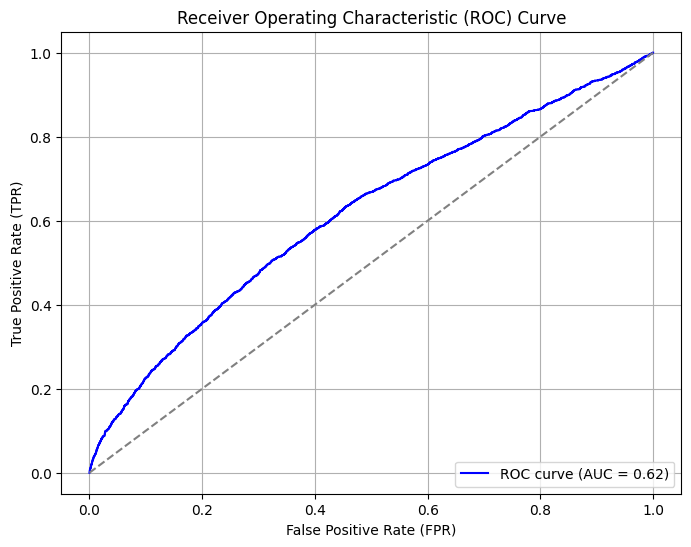

In [222]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities (for class 1)
y_prob = model.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line (diagonal)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

AdaboostClassifier model below:

In [219]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Step 2: Apply AdaBoost with the Decision Tree as the base learner
ada_boost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Step 3: Fit AdaBoost model on the training data
ada_boost.fit(X_train_pca, y_train_resampled)

# Step 4: Make predictions
y_pred = ada_boost.predict(X_test_pca)

# Step 5: Evaluate the model
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score:  0.6428930944231931
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.66      0.77     17605
           1       0.17      0.53      0.25      2263

    accuracy                           0.64     19868
   macro avg       0.54      0.59      0.51     19868
weighted avg       0.83      0.64      0.71     19868

Confusion Matrix:
 [[11572  6033]
 [ 1062  1201]]


AUC for Adaboost

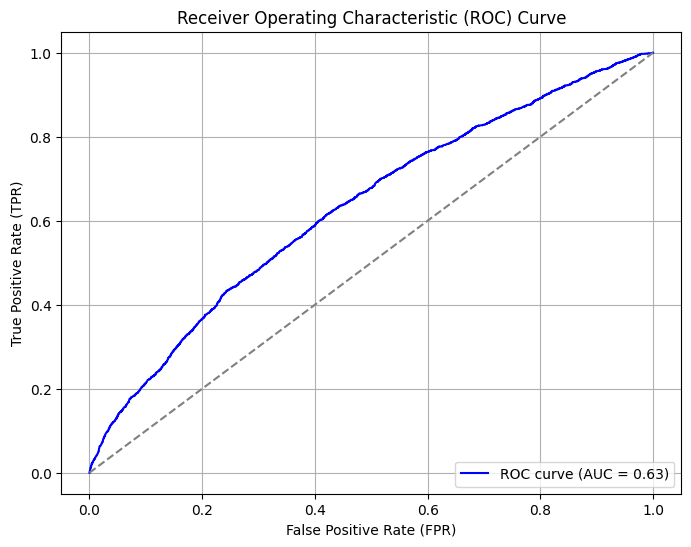

In [223]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities (for class 1)
y_prob = ada_boost.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line (diagonal)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Random Forest Classifier:

In [191]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # You can tweak parameters

# Fit the model to training data
rf_model.fit(X_train_pca, y_train_resampled)

y_pred = rf_model.predict(X_test_pca)

# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Classification Report (Precision, Recall, F1-score)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)


Accuracy: 0.8238
Confusion Matrix:
 [[15952  1653]
 [ 1847   416]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     17605
           1       0.20      0.18      0.19      2263

    accuracy                           0.82     19868
   macro avg       0.55      0.54      0.55     19868
weighted avg       0.82      0.82      0.82     19868



AUC for Random Forest:

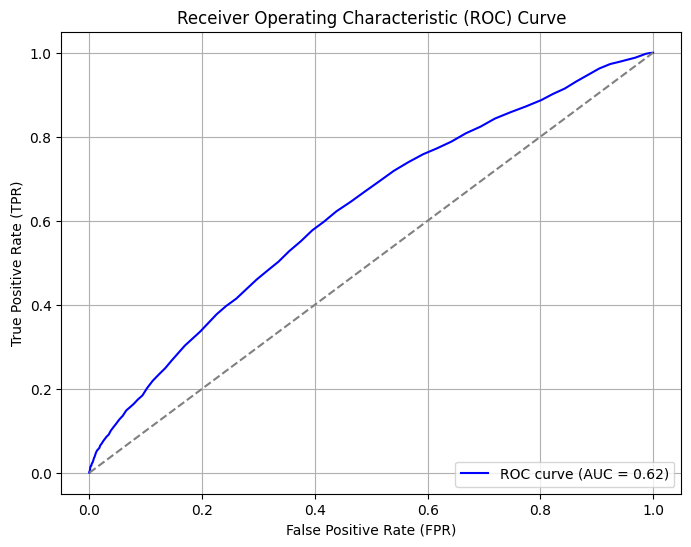

In [194]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities (for class 1)
y_prob = rf_model.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line (diagonal)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Xgboost model below:

In [195]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',       # Evaluation metric for binary classification
    use_label_encoder=False,     # Avoid deprecated warnings
    random_state=42
)

# Train the model
xgb_model.fit(X_train_pca, y_train_resampled)

# Predict on the test set
y_pred = xgb_model.predict(X_test_pca)
y_pred_proba = xgb_model.predict_proba(X_test_pca)[:, 1]  # For ROC AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:53:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[13145  4460]
 [ 1330   933]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     17605
           1       0.17      0.41      0.24      2263

    accuracy                           0.71     19868
   macro avg       0.54      0.58      0.53     19868
weighted avg       0.82      0.71      0.75     19868


ROC AUC Score:
0.6179022826615836


AUC for xgb model:

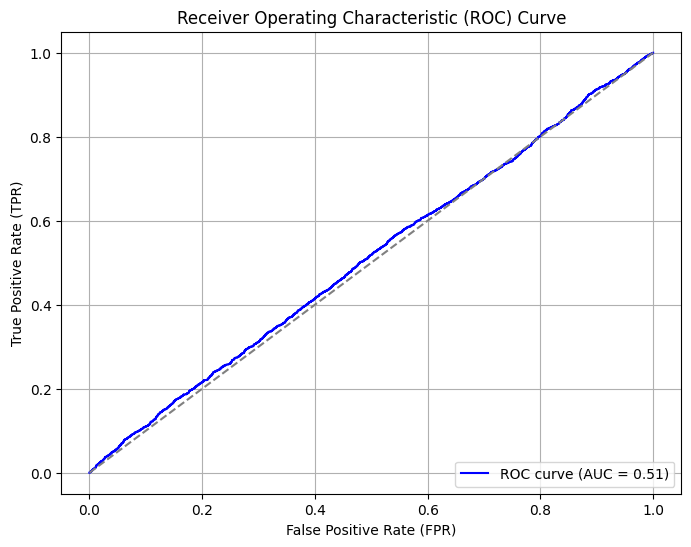

In [224]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities (for class 1)
y_prob = xgb_model.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line (diagonal)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

GridSearchCV model:

In [225]:
##TAKES FOREVER

from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=100,
    n_jobs=-1
)

grid_search.fit(X_train_pca, y_train_resampled)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


Grid Search AUC:

Confusion Matrix:
[[14436  3169]
 [ 1537   726]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     17605
           1       0.19      0.32      0.24      2263

    accuracy                           0.76     19868
   macro avg       0.55      0.57      0.55     19868
weighted avg       0.82      0.76      0.79     19868


ROC AUC Score: 0.604589344182365


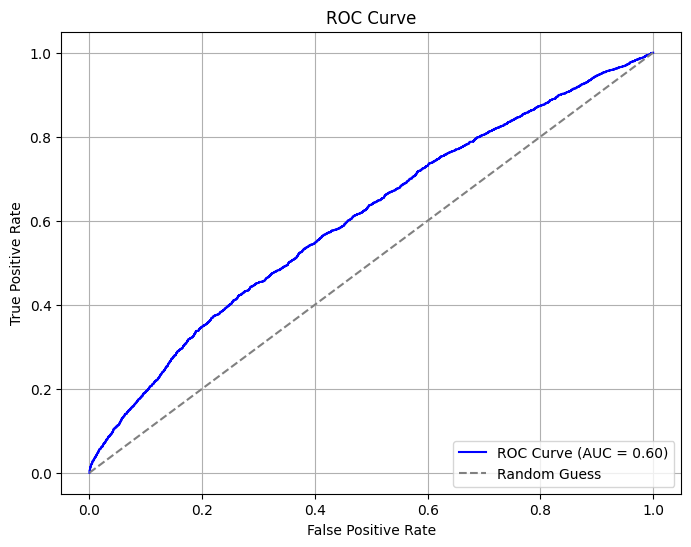

In [226]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = best_model.predict(X_test_pca)
y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]  # Probabilities for the positive class

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\nROC AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
